In [2]:
%pip install numpy matplotlib scipy pandas seaborn scikit-learn statsmodels plotly

     -------------------------------------- 294.9/294.9 kB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 9.8/9.8 MB 30.0 MB/s eta 0:00:00
     --------------------------------------- 19.1/19.1 MB 15.6 MB/s eta 0:00:00
     ---------------------------------------- 232.9/232.9 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


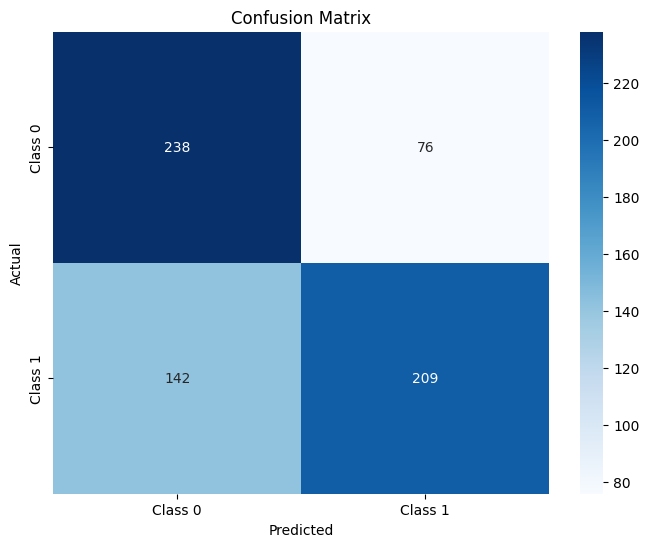

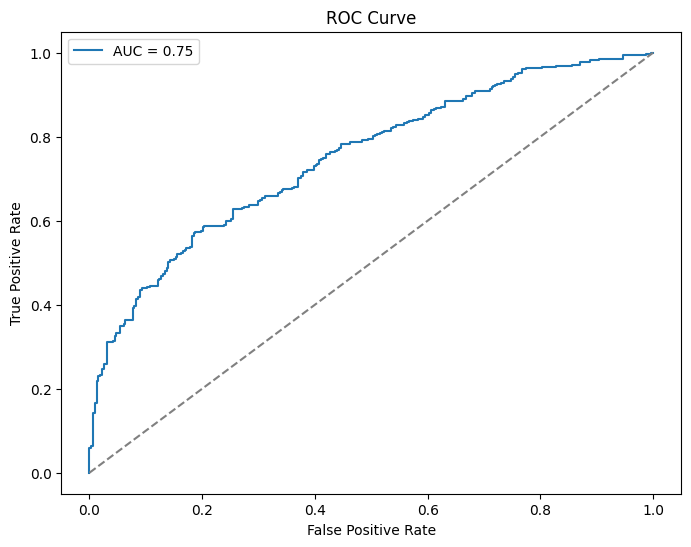

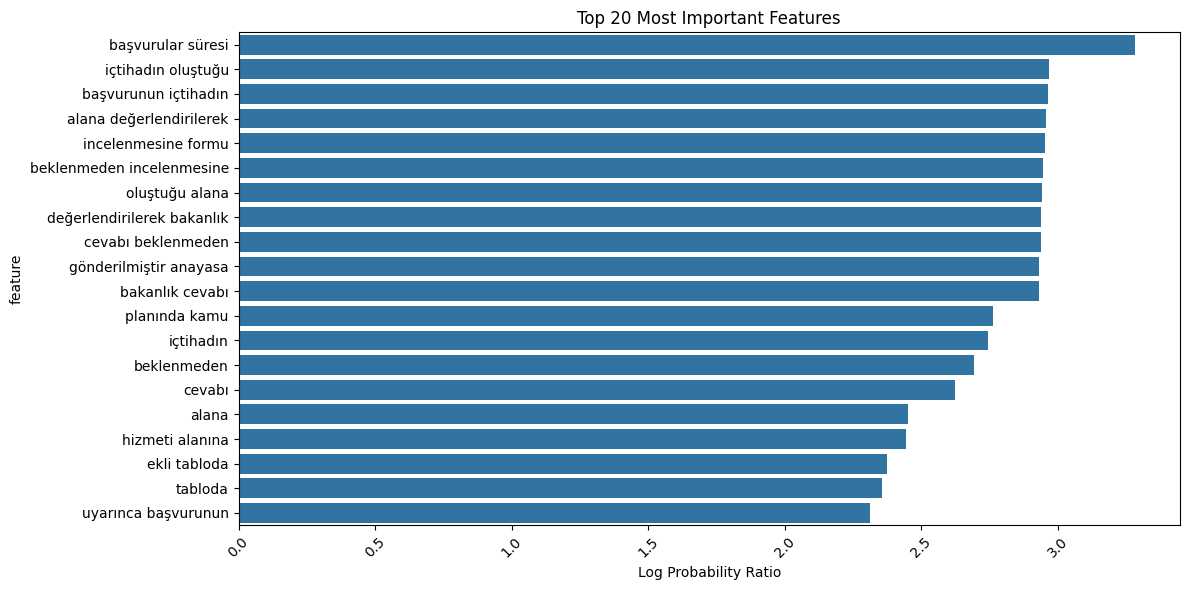

Accuracy: 0.67
Cross-Validation Scores: [0.66930693 0.67789223 0.67789223 0.69809826 0.68779715]
Mean CV Accuracy: 0.68
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.63      0.76      0.69       314
     Class 1       0.73      0.60      0.66       351

    accuracy                           0.67       665
   macro avg       0.68      0.68      0.67       665
weighted avg       0.68      0.67      0.67       665

ROC-AUC Score: 0.75

Top 10 Most Discriminative Features:
                         feature  importance
764            başvurular süresi    3.284137
2488          içtihadın oluştuğu    2.966772
774         başvurunun içtihadın    2.966188
364      alana değerlendirilerek    2.958460
2376         incelenmesine formu    2.955350
794    beklenmeden incelenmesine    2.945757
3427              oluştuğu alana    2.943366
1277  değerlendirilerek bakanlık    2.940161
1075          cevabı beklenmeden    2.939546
1861      gönderilmiş

In [2]:
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                           roc_auc_score, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
def load_json_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return pd.DataFrame(json.load(file))

# Load datasets
train_data = load_json_data('C:/Users/muham/Documents/GitHub/CSE4288F24_Grp4/Phase (2) - Data Processing & EDA/Preprocessed Data/training_dataset.json')
development_data = load_json_data('C:/Users/muham/Documents/GitHub/CSE4288F24_Grp4/Phase (2) - Data Processing & EDA/Preprocessed Data/development_dataset.json')
test_data = load_json_data('C:/Users/muham/Documents/GitHub/CSE4288F24_Grp4/Phase (2) - Data Processing & EDA/Preprocessed Data/testing_dataset.json')

# Extract features and labels for all datasets
def prepare_features_and_labels(data, vectorizer=None):
    if vectorizer is None:
        vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
        features = vectorizer.fit_transform(data['text'])
    else:
        features = vectorizer.transform(data['text'])
    labels = data['labels']
    return features, labels, vectorizer

# Prepare features and labels
X_train, y_train, vectorizer = prepare_features_and_labels(train_data)
X_dev, y_dev, _ = prepare_features_and_labels(development_data, vectorizer)
X_test, y_test, _ = prepare_features_and_labels(test_data, vectorizer)

# Combine training and development data for final model training
X_combined = np.vstack([X_train.toarray(), X_dev.toarray()])
y_combined = np.hstack([y_train, y_dev])

# Train Naive Bayes model
model = MultinomialNB()
model.fit(X_combined, y_combined)

# Model Evaluation
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions, target_names=['Class 0', 'Class 1'])
roc_auc = roc_auc_score(y_test, probabilities)

# Cross-Validation (for robustness)
cross_val_scores = cross_val_score(model, X_combined, y_combined, cv=5, scoring='accuracy')

# Feature Importance Analysis
feature_names = vectorizer.get_feature_names_out()
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_log_prob_[1] - model.feature_log_prob_[0]  # Log probability ratio
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Visualizations
# 1. Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, probabilities)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 3. Top Features Plot
plt.figure(figsize=(12, 6))
top_features = feature_importance.head(20)
sns.barplot(data=top_features, x='importance', y='feature')
plt.title('Top 20 Most Important Features')
plt.xlabel('Log Probability Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save processed datasets
train_data.to_json('processed_training_dataset.json', orient='records', force_ascii=False)
development_data.to_json('processed_development_dataset.json', orient='records', force_ascii=False)
test_data.to_json('processed_testing_dataset.json', orient='records', force_ascii=False)

# Save feature importance analysis
feature_importance.to_csv('feature_importance.csv', index=False)

# Performance Summary
print(f"Accuracy: {accuracy:.2f}")
print("Cross-Validation Scores:", cross_val_scores)
print(f"Mean CV Accuracy: {np.mean(cross_val_scores):.2f}")
print("Classification Report:\n", class_report)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Print top discriminative features
print("\nTop 10 Most Discriminative Features:")
print(feature_importance.head(10))

In [1]:
%pip install shap lime

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  DEPRECATION: lime is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To updat

     -------------------------------------- 456.1/456.1 kB 2.2 MB/s eta 0:00:00
     -------------------------------------- 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 2.7/2.7 MB 19.1 MB/s eta 0:00:00
     --------------------------------------- 11.1/11.1 MB 26.2 MB/s eta 0:00:00
     --------------------------------------- 12.9/12.9 MB 38.4 MB/s eta 0:00:00
     --------------------------------------- 44.8/44.8 MB 32.7 MB/s eta 0:00:00
     --------------------------------------- 11.6/11.6 MB 40.9 MB/s eta 0:00:00
     ---------------------------------------- 78.5/78.5 kB ? eta 0:00:00
     ---------------------------------------- 8.0/8.0 MB 39.5 MB/s eta 0:00:00
     --------------------------------------- 12.8/12.8 MB 25.2 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 23.2 MB/s eta 0:00:00
     -----------------------

In [ ]:
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                           roc_auc_score, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import lime
import lime.lime_text
import shap
from lime.lime_text import LimeTextExplainer
import warnings
warnings.filterwarnings('ignore')

# Load and preprocess data
def load_json_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return pd.DataFrame(json.load(file))

# Load datasets
train_data = load_json_data('C:/Users/muham/Documents/GitHub/CSE4288F24_Grp4/Phase (2) - Data Processing & EDA/Preprocessed Data/training_dataset.json')
development_data = load_json_data('C:/Users/muham/Documents/GitHub/CSE4288F24_Grp4/Phase (2) - Data Processing & EDA/Preprocessed Data/development_dataset.json')
test_data = load_json_data('C:/Users/muham/Documents/GitHub/CSE4288F24_Grp4/Phase (2) - Data Processing & EDA/Preprocessed Data/testing_dataset.json')

# Extract features and labels for all datasets
def prepare_features_and_labels(data, vectorizer=None):
    if vectorizer is None:
        vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
        features = vectorizer.fit_transform(data['text'])
    else:
        features = vectorizer.transform(data['text'])
    labels = data['labels']
    return features, labels, vectorizer

# Prepare features and labels
X_train, y_train, vectorizer = prepare_features_and_labels(train_data)
X_dev, y_dev, _ = prepare_features_and_labels(development_data, vectorizer)
X_test, y_test, _ = prepare_features_and_labels(test_data, vectorizer)

# Combine training and development data for final model training
X_combined = np.vstack([X_train.toarray(), X_dev.toarray()])
y_combined = np.hstack([y_train, y_dev])

# Train Naive Bayes model
model = MultinomialNB()
model.fit(X_combined, y_combined)

# Model Evaluation
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]

# Basic metrics
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions, target_names=['Class 0', 'Class 1'])
roc_auc = roc_auc_score(y_test, probabilities)

# Cross-Validation
cross_val_scores = cross_val_score(model, X_combined, y_combined, cv=5, scoring='accuracy')

# LIME Explanation Setup
class_names = ['Class 0', 'Class 1']
lime_explainer = LimeTextExplainer(class_names=class_names)

def get_lime_explanation(text_instance, num_features=10):
    # Create pipeline-style predict_proba function
    def predict_proba_pipeline(texts):
        return model.predict_proba(vectorizer.transform(texts))
    
    # Generate explanation
    exp = lime_explainer.explain_instance(
        text_instance, 
        predict_proba_pipeline,
        num_features=num_features
    )
    return exp

# SHAP Explanation Setup
# Convert sparse matrix to dense for SHAP
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Initialize SHAP explainer
shap_explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_train_dense, 100))

# Generate SHAP values for test set
shap_values = shap_explainer.shap_values(X_test_dense[:100])  # Using first 100 samples for computation efficiency

# Visualization Functions
def plot_lime_explanation(exp, title="LIME Explanation"):
    plt.figure(figsize=(10, 6))
    exp.as_pyplot_figure()
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_shap_summary():
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values[1], X_test_dense[:100], 
                     feature_names=vectorizer.get_feature_names_out(),
                     plot_type="bar")
    plt.title("SHAP Feature Importance Summary")
    plt.tight_layout()
    plt.show()

# Generate explanations for a sample instance
sample_idx = 0  # Choose first test instance
sample_text = test_data['text'].iloc[sample_idx]
sample_prediction = predictions[sample_idx]

# LIME explanation for sample
lime_exp = get_lime_explanation(sample_text)
plot_lime_explanation(lime_exp, f"LIME Explanation for Sample Text (Predicted: Class {sample_prediction})")

# SHAP summary plot
plot_shap_summary()

# Original visualizations
# 1. Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, probabilities)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Save results and explanations
# Save LIME explanation
lime_exp_dict = {
    'text': sample_text,
    'prediction': int(sample_prediction),
    'explanation': lime_exp.as_list()
}
with open('lime_explanation.json', 'w') as f:
    json.dump(lime_exp_dict, f, indent=2)

# Save SHAP values
np.save('shap_values.npy', shap_values)

# Performance Summary
print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Mean CV Accuracy: {np.mean(cross_val_scores):.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(class_report)

# LIME Explanation Summary
print("\nLIME Explanation for Sample Text:")
print(f"Predicted Class: {sample_prediction}")
print("\nTop Features contributing to prediction:")
for feature, importance in lime_exp.as_list()[:5]:
    print(f"{feature}: {importance:.4f}")

# SHAP Summary
print("\nSHAP Analysis:")
print("Top 5 most important features based on mean absolute SHAP values:")
mean_shap_values = np.abs(shap_values[1]).mean(0)
feature_importance = pd.DataFrame({
    'feature': vectorizer.get_feature_names_out(),
    'importance': mean_shap_values
})
print(feature_importance.nlargest(5, 'importance'))

c:\Users\muham\AppData\Local\Programs\Python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/100 [00:05<?, ?it/s]


MemoryError: Unable to allocate 43.0 GiB for an array with shape (11546, 500000) and data type float64